# 3 Red Cards Study

In [1]:
# imports
import sklearn
from sklearn.datasets import load_digits 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os

## 3.1 Loading and Cleaning the Data

In [2]:
# load data
filename = 'data\CrowdstormingDataJuly1st.csv'
print(filename)
df = pd.read_csv(filename)
print(df.columns)
print(df.info)

data\CrowdstormingDataJuly1st.csv
Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')
<bound method DataFrame.info of                   playerShort                 player                  club  \
0               lucas-wilchez          Lucas Wilchez         Real Zaragoza   
1                  john-utaka             John Utaka       Montpellier HSC   
2                 abdon-prats            Abdón Prats          RCD Mallorca   
3                  pablo-mari             Pablo Marí          RCD Mallorca   
4                  ruben-pena             Rubén Peña       Real Valladolid   
5                aaron-hughes           Aaron Hughes             Fulham FC   
6          aleksandar-k

In [3]:
# test data access
df[df['playerShort']=='mesut-oezil']['refNum'][:4] # all referees in games with mesut oezil

26       4
1051    66
1773    72
2852    88
Name: refNum, dtype: int64

In [4]:
# data cleaning

# drop players without skin color rating
df = df.dropna(subset=['rater1','rater2'])

Text(0.5, 1.0, 'Frequent referees')

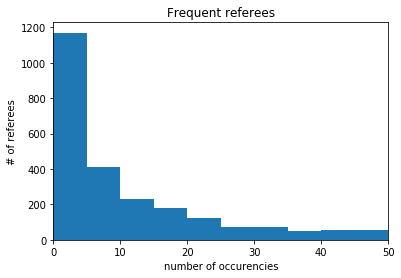

In [5]:
# plot referee occurencies
refnum_unique = np.unique(df['refNum'],return_counts=True,return_index=True)
plt.hist(refnum_unique[2],bins=np.arange(100)*5)
plt.xlim(0,50)
plt.xlabel('number of occurencies')
plt.ylabel('# of referees')
plt.title('Frequent referees')

There is a large number of referees, who appear less then ten times in the data set. This is especially troubeling as we would expect a referee who leads one game in the one of the studied leagues to appear at least 22 times - one time in combination with each player of the two teams. We thus exclude all referees with less than 22 occurencies.

In [6]:
#exclude referees with less than 22 occurencies

df = df[[rn not in refnum_unique[0][np.where(refnum_unique[2]<22)[0]] for rn in df['refNum']]]

In [7]:
# new features
players,players_id = np.unique(df['playerShort'],return_index=True)
occurencies = [[df['playerShort']==player] for player in players]
dfage = 2013 - np.array([int(b[-4:]) for b in df['birthday'].values]) # age at the end of the season in years
age = dfage[np.unique(df['playerShort'],return_index=True)[1]]
totalRedCards = np.array([np.sum(df[occ[0]]['redCards']) for occ in occurencies])
totalGames =   np.array([np.sum(df[occ[0]]['games']) for occ in occurencies])
averageRedCards = totalRedCards/totalGames

# add further features from original df
leagueCountry = df.iloc[players_id]['leagueCountry']
position = df.iloc[players_id]['position']

b2i = lambda barr: [np.int(b) for b in barr]

league_eng = b2i(np.array([leagueCountry=='England'][0]))
league_ger =  b2i(np.array([leagueCountry=='Germany'][0]))
league_fra =  b2i(np.array([leagueCountry=='France'][0]))
league_spa =  b2i(np.array([leagueCountry=='Spain'][0]))

pos_back =  b2i(['Back' in str(pos) or 'back' in str(pos) for pos in position])
pos_keep =  b2i(['keeper' in str(pos) for pos in position])
pos_mid =  b2i(['Midfield' in str(pos) for pos in position])
pos_for =  b2i(['Forward' in str(pos)for pos in position])
pos_wing =  b2i(['Winger' in str(pos) for pos in position])

### Data Visualisation

Text(0, 0.5, 'red cards per game')

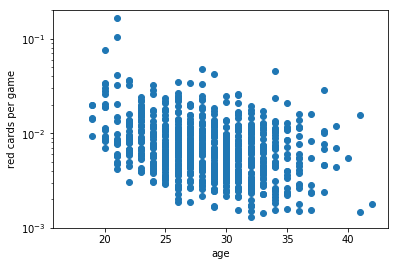

In [8]:
plt.scatter(age,averageRedCards)
plt.xlabel('age')
plt.yscale('log')
plt.ylim(1e-3,0.2)
plt.ylabel('red cards per game')

Text(0.5, 1.0, 'skin color ratings')

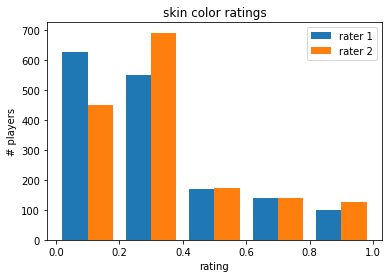

In [9]:
# visualise skin color ratings

# rater 1
rat1 = df.iloc[np.unique(df['playerShort'],return_index=True)[1]]['rater1']

# rater 2
rat2 = df.iloc[np.unique(df['playerShort'],return_index=True)[1]]['rater2']

plt.hist([rat1,rat2],bins=5)
plt.legend(['rater 1','rater 2'])
plt.xlabel('rating')
plt.ylabel('# players')
plt.title('skin color ratings')

We observe that the raters asign different numbers of players to the skin color classes. There are also much more players with very light or light skin color than players with dark or very dark skin color. 

Rater 2 assignes lighter skin color more often than rater 1.

[-0.5  -0.25  0.    0.25]
mean difference: -0.04182449494949495
std difference: 0.11593827601116938


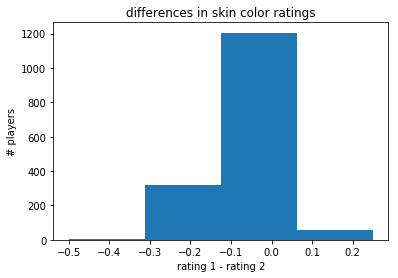

In [10]:
# differences in color ratings
diffrat = rat1 - rat2 
print(np.unique(diffrat))
plt.hist(diffrat,bins=4) 
plt.xlabel('rating 1 - rating 2')
plt.ylabel('# players')
plt.title('differences in skin color ratings')

print('mean difference:', np.mean(diffrat))
print('std difference:', np.std(diffrat))

Rater 2 assignes lighter skin color more often than rater 1. The standard deviation of the differences is roughly half the size of the difference between to neighbouring skin tones. Excluding data where the diffence is large will improve the accuracy of our analysis. Alternatively, we could take the mean between the both ratings.

9


Text(0.5, 1.0, 'mean of skin color ratings')

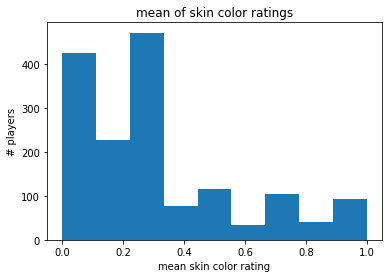

In [11]:
# mean color ratings
meanrat = 0.5*(rat1 + rat2)
print(len(np.unique(meanrat)))
plt.hist(meanrat,bins=9) 
plt.xlabel('mean skin color rating')
plt.ylabel('# players')
plt.title('mean of skin color ratings')

1205


C:\Program Files\Anaconda3\lib\site-packages\pandas\core\series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'mean of skin color ratings')

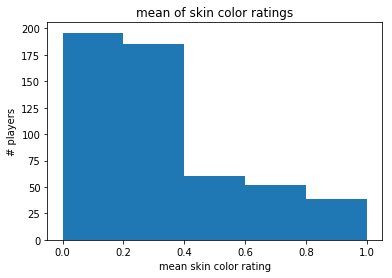

In [12]:
# mean color ratings
ratboth = rat1[np.where(rat1==rat2)[0]]
print(len(ratboth))
plt.hist(ratboth,bins=5) 
plt.xlabel('mean skin color rating')
plt.ylabel('# players')
plt.title('mean of skin color ratings')

Text(0, 0.5, 'red cards per game')

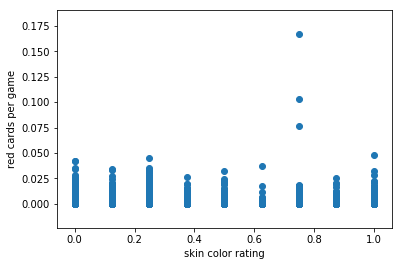

In [13]:
plt.scatter(meanrat,averageRedCards)
plt.xlabel('skin color rating')
plt.ylabel('red cards per game')

In [14]:
# darker skin by league

ind = [meanrat>0.5][0].values

leagues = [league_eng,league_spa,league_fra,league_ger]
inl = [100*np.sum(l*ind)/np.sum(l) for l in leagues]
print('Fraction of players with skin colour rating above 0.5\n-------------------------\nEngland: %0.1f percent\nSpain: %0.1f percent\nFrance: %0.1f percent\nGermany: %0.1f percent\n' %(inl[0],inl[1],inl[2],inl[3],))

Fraction of players with skin colour rating above 0.5
-------------------------
England: 21.2 percent
Spain: 8.2 percent
France: 37.2 percent
Germany: 9.6 percent



In Spain and in Germany, there are less players with dark skin than in France or England.

### Final Dataset

In [15]:
# gather data
data = np.array([meanrat,age,totalGames,league_fra,league_ger,pos_keep,pos_back,pos_mid,pos_wing,pos_for])
names = np.array(['mean rating','age','games','French league','German league','goalkeeper','back','midfield','wings','forward'])

# remove players with no red cards
X_all = data.T[np.where(averageRedCards > 0)[0],:]
y_all = averageRedCards[np.where(averageRedCards > 0)[0]]

X_train , X_test , y_train , y_test =\
model_selection.train_test_split( X_all , y_all , test_size = 0.4 , random_state = 0)

In [16]:
print(len(X_train))

484


We remove players with no red cards. We aim to investigate the probability of a player to receive a red card in a match. As an estimator for the probability, we use the average number of red cards a player has received during his career. If a player has never received a red card, the average will give zero, but the underlaying probability is not.

## 3.2 Model Creation

### Linear Regression

In [17]:
# linear regression
def linreg(X,y):
    # y = b*x + c
    
    # centralize data
    Xc = np.array([x - np.mean(x) for x in X.T]).T 
    yc = y - np.mean(y)
    
    # cholevski factorization
    R = np.linalg.cholesky(np.matmul(Xc.T,Xc))
    y_ = np.matmul(Xc.T,yc)

    # find z by forward substitution
    z = [y_[0]*R[0,0]**-1]
    for m in np.arange(1,Xc.shape[1]):
        z.append((y_[m]-np.sum(R[m,:m]*np.array(z)))*R[m,m]**-1)

    # find beta by backwards substitution
    beta = [z[Xc.shape[1]-1]*R.T[Xc.shape[1]-1,Xc.shape[1]-1]**-1]
    for m in np.arange(2,Xc.shape[1]+1):
        beta.append((z[Xc.shape[1]-m]-np.sum(R.T[Xc.shape[1]-m,Xc.shape[1]-m+1:]*np.array(beta[::-1])))*R[Xc.shape[1]-m,Xc.shape[1]-m]**-1)

    # compute offset c
    c  = np.mean(y - np.sum(np.array([X[:,i]*beta[::-1][i] for i in range(X.shape[1])]),axis=0))

    return [np.array(beta[::-1]),c]


def linregpred(X,beta,c):
    return np.sum(X*beta)+c


# proper class defintition
class LinRegMod:
    def __init__(self):
        self.beta = []
        self.c = []
            
    def fit(self,X,y):
        # y = b*x + c

        # centralize data
        Xc = np.array([x - np.mean(x) for x in X.T]).T 
        yc = y - np.mean(y)

        # cholevski factorization
        R = np.linalg.cholesky(np.matmul(Xc.T,Xc))
        y_ = np.matmul(Xc.T,yc)

        # find z by forward substitution
        z = [y_[0]*R[0,0]**-1]
        for m in np.arange(1,Xc.shape[1]):
            z.append((y_[m]-np.sum(R[m,:m]*np.array(z)))*R[m,m]**-1)

        # find beta by backwards substitution
        beta = [z[Xc.shape[1]-1]*R.T[Xc.shape[1]-1,Xc.shape[1]-1]**-1]
        for m in np.arange(2,Xc.shape[1]+1):
            beta.append((z[Xc.shape[1]-m]-np.sum(R.T[Xc.shape[1]-m,Xc.shape[1]-m+1:]*np.array(beta[::-1])))*R[Xc.shape[1]-m,Xc.shape[1]-m]**-1)
        
        self.beta = beta[::-1]
        
        # compute offset c
        self.c  = np.mean(y - np.sum(np.array([X[:,i]*beta[::-1][i] for i in range(X.shape[1])]),axis=0))

    def predict(self,X):
        return np.sum(X*self.beta)+self.c

In [18]:
# experimenting by only using skin color rating and age


#X = X_train[np.where(y_train>0)[0],:2]
#y = y_train[np.where(y_train>0)[0]]

X = X_all[:,:2]
y = y_all

res = linreg(X,y)
print('c = ',res[1])
pd.DataFrame(data=[res[0]],columns=names[:len(res[0])],index=['beta'])


c =  0.024086462027281045


,mean rating,age
beta,0.003022,-0.000568


Text(0, 0.5, 'red cards per game')

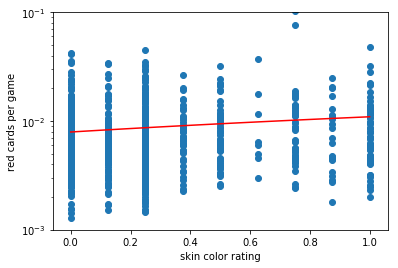

In [19]:
xrange = np.linspace(np.min(X[:,0]),np.max(X[:,0]),100)

plt.scatter(X[:,0],y)
plt.plot(xrange,res[0][0]*xrange + res[0][1]*np.mean(X[:,1]) + res[1],color='red')
plt.yscale('log')
plt.ylim(1e-3,1e-1)
plt.xlabel('skin color rating')
plt.ylabel('red cards per game')

Text(0, 0.5, 'red cards per game')

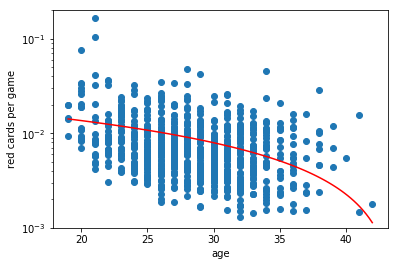

In [20]:
xrange = np.linspace(np.min(X[:,1]),np.max(X[:,1]),100)

plt.scatter(X[:,1],y)
plt.plot(xrange,res[0][1]*xrange + res[0][0]*np.mean(X[:,0]) + res[1],color='red')
plt.yscale('log')
plt.ylim(1e-3,0.2)
plt.xlabel('age')
plt.ylabel('red cards per game')

### Regression Forest

In [21]:
# classes adopted from the previous exercise

class Node:
    pass

class Tree:
    def __init__(self):
        self.root = Node()
    
    def find_leaf(self, x):
        node = self.root
        while hasattr(node, "feature"):
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node

        
class RegressionTree(Tree):
    def __init__(self):
        super(RegressionTree, self).__init__()
        
    def fit(self, data, labels, n_min=20):

        N, D = data.shape
        D_try = int(np.sqrt(D)) # how many features to consider for each split decision
                    # consider all as the number of features is small

        # initialize the root node
        self.root.data = data
        self.root.labels = labels
        
        #put root in stack
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            
            perm = np.random.permutation(D)   # permute D indices
            
            uniqueness = np.any([len(np.unique(node.data[:,i])) > 1 for i in perm[:D_try]])
            
            if n >= n_min and uniqueness == True:
                # Call 'make_decision_split_node()' with 'D_try' randomly selected 
                # feature indices. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                
                left, right = make_regression_split_node(node, perm[:D_try]) #select :D_try of permuted indices
                                                       #for 'make_decision_split_node()'
                # put children in stack
                stack.append(left)
                stack.append(right)
                
            else:
                # Call 'make_decision_leaf_node()' to turn 'node' into a leaf node.
                make_regression_leaf_node(node)
                
    def predict(self, x):
        leaf = self.find_leaf(x)
        # compute p(y | x)
        return leaf.response 
    


def make_regression_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape

    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = 1e100
    j_min, t_min = 0, 0
    for j in feature_indices:
        # remove duplicate features
        dj = np.sort(np.unique(node.data[:,j]))

        # compute candidate thresholds in the middle between consecutive feature values
        tj = 0.5 * (dj[1:] + dj[:-1]) 
        # each candidate threshold we need to compute squared error of the resulting children node
        for t in tj:
            left_indices = node.data[:,j] <= t
            nl = np.sum(left_indices)
            ll = node.labels[left_indices]
            el = np.sum((ll-np.mean(ll))**2)
            nr = n - nl
            lr = node.labels[node.data[:,j] > t]
            er = np.sum((lr-np.mean(lr))**2)
            # choose the the best threshold that minimizes sum of Gini impurities
            if el + er < e_min:
                e_min = el + er
                j_min = j
                t_min = t



    # create children
    left = Node()
    right = Node()
    
    # initialize 'left' and 'right' with the data subsets and labels
    # according to the optimal split found above
    left.data = node.data[node.data[:,j_min] <= t_min, :]
    left.labels = node.labels[node.data[:,j_min] <= t_min]
    right.data = node.data[node.data[:,j_min] > t_min, :]
    right.labels = node.labels[node.data[:,j_min] > t_min]

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min
      
    
    # return the children (to be placed on the stack)
    return left, right    

def make_regression_leaf_node(node):
    '''
    node: the node to become a leaf
    '''
    node.N = node.labels.shape[0]
    node.response = np.mean(node.labels) / node.N
    
class RegressionForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [RegressionTree() for i in range(n_trees)]
    
    def fit(self, data, labels, n_min=0):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            bootstrap = np.random.choice(len(data), size=len(data))
            tree.fit(data[bootstrap], labels[bootstrap], n_min)

    def predict(self, x):
        # compute the ensemble prediction
        return np.mean([tree.predict(x) for tree in self.trees], axis=0)

### Test error

In [22]:
# train linear regression model

print('\nlinear regression model\n----------------------------')

lrm = LinRegMod()
lrm.fit(X_train, y_train)

# test error
err_test = np.mean([(lrm.predict(X_test[i])-y_test[i])**2 for i in range(len(X_test))])
print('mean test error = ',err_test/np.std(y_test)**2)


linear regression model
----------------------------
mean test error =  0.759235693267782


In [23]:
# training one instance of RegressionForest

print('\nregression forest\n----------------------------')

rf = RegressionForest(10)
rf.fit(X_train, y_train, 20)

# test error

err_test = np.mean([(rf.predict(X_test[i])-y_test[i])**2 for i in range(len(X_test))])
print('mean test error = ',err_test/np.std(y_test)**2)


regression forest
----------------------------
mean test error =  1.5124577680694533


We scale the squared test error by the variance, which results in a more intuitive quantity then simply the squared error. It can also be more easily be compared.

The error for the test set is larger for the regression forest. A smaller error could be achieved by lowering n_min or increasing the size of the training set.

### Cross-validation

In [24]:
# cross validation

def leave_one_cv(model,X,y,N):
    # leave one out cross validation
    err = []

    I = np.random.permutation(len(X))[:N]

    for i in I:
        model.fit(np.delete(X,i,axis=0), np.delete(y,i))
        y_pred = model.predict(X[i])

        err.append((y[i]-y_pred)**2)

    return np.mean(err)/np.std(y)**2

In [25]:
# leave one out cross-validation linear regression

model = LinRegMod()

score_lrm = leave_one_cv(model,X_all,y_all,len(X_all))

print('mean deviation from prediction: ',score_lrm)

mean deviation from prediction:  0.8249450792622764


Cross-validation indicates a good accuracy.

In [26]:
# leave one out cross-validation linear regression

model = RegressionForest(10)

score_rf = leave_one_cv(model,X_all,y_all,10)

print('mean deviation from prediction: ',score_rf)

mean deviation from prediction:  0.6661294782891204


The error for the regression forest shrinks for the larger training set. However, we use only a small number of crossings for the regression forest due to the large computation time.

## 3.3 Answering the Research Question

In [27]:
# create 19 new data sets

X = X_all[:,:]
y = y_all

shuffledSet = [X.copy() for i in range(19)]

for Xnew in shuffledSet:
    Xnew[:,0] = X[:,0][np.random.permutation(len(X))]

In [28]:
# leave one out cross-validation linear regression

print('\nlinear regression model\n----------------------------')

score = []

for Xnew in shuffledSet:

    score.append(leave_one_cv(LinRegMod(),Xnew,y,len(X)))

print('number of sets for which error increased: ',len(np.where(score>score_lrm)[0]))
print('mean deviation from prediction: ',np.mean(score))
print('standard deviation of deviation from prediction: ',np.std(score))


linear regression model
----------------------------
number of sets for which error increased:  18
mean deviation from prediction:  0.8286188631758438
standard deviation of deviation from prediction:  0.0016745913763320556


The squared error is slightly increased when permutating the color ratings. This shows a correlation between the skin color rating and average red cards per game.

In [29]:
# leave one out cross-validation regression forest

print('\nregression forest\n----------------------------')

score = []

for Xnew in shuffledSet:

    score.append(leave_one_cv(RegressionForest(10),Xnew,y,10))

print('number of sets for which error increased: ',len(np.where(score>score_rf)[0]))
print('mean deviation from prediction: ',np.mean(score))
print('standard deviation of deviation from prediction: ',np.std(score))


regression forest
----------------------------
number of sets for which error increased:  7
mean deviation from prediction:  0.7268111272671135
standard deviation of deviation from prediction:  0.4062397297037986


The result regarding the regression forest is less clear as can be seen from the large standard deviation. We did not perform a full cross.validation but used only a small randomly selected subset because the computation time would be to large otherwise.

In [30]:
print('Mean red cards per game by skin color rating')
print('----------------------------------------------------')

print('light skin colors (rating < 0.5)')
print(np.mean(y_all[np.where(X_all[:,0]<0.5)]))

print('\ndark skin colors (rating > 0.5)')

print(np.mean(y_all[np.where(X_all[:,0]>0.5)]))

Mean red cards per game by skin color rating
----------------------------------------------------
light skin colors (rating < 0.5)
0.008183059612957413

dark skin colors (rating > 0.5)
0.011710184342505548


The mean red cards per game are slightly increased for players with dark skin colors.

### Alternative Cleaning


### Alternative Hypothesis

(i) Leagues

The fraction of players with dark skin colors varies between the leagues. So the number of players with dark skin color is correlated with the league they are playing in.
Then, the interpretation of rules could vary inbetween leagues, which would result in a correlation between the number of red cards and league. As a conequence, the skin color would also be correlated to the number of red cards.

(ii) Youth

The countries under investigation became increasingly multicultural and additionally their leagues became more international over the last decades. Thus, there could be a correlation between skin color and the age of players. 
Young players might have different tactics due to different physical capabilities and experience. This could lead to a difference in red cards received by young versus old players. 
In combination, both effects could lead to a correlation between red cards and skin color.